Training:  10%|█         | 51/500 [00:04<00:39, 11.38it/s]

Episode 50/500: Duration = 10


Training:  20%|██        | 100/500 [00:09<00:53,  7.51it/s]

Episode 100/500: Duration = 31


Training:  30%|███       | 150/500 [01:25<10:48,  1.85s/it]

Episode 150/500: Duration = 291


Training:  40%|████      | 200/500 [02:51<08:07,  1.62s/it]

Episode 200/500: Duration = 284


Training:  50%|█████     | 250/500 [05:07<11:31,  2.77s/it]

Episode 250/500: Duration = 297


Training:  60%|██████    | 300/500 [07:54<12:29,  3.75s/it]

Episode 300/500: Duration = 360


Training:  70%|███████   | 350/500 [11:11<09:46,  3.91s/it]

Episode 350/500: Duration = 495


Training:  80%|████████  | 400/500 [14:34<08:03,  4.83s/it]

Episode 400/500: Duration = 391


Training:  90%|█████████ | 450/500 [18:18<04:09,  4.99s/it]

Episode 450/500: Duration = 500


Training: 100%|██████████| 500/500 [22:37<00:00,  2.72s/it]

Episode 500/500: Duration = 500


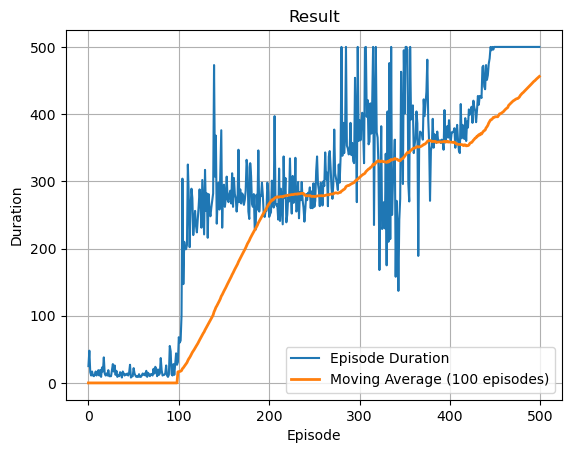

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import random
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm import tqdm
from itertools import count

# Neural Network for Dueling DQN
class DuelingDQNModel(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingDQNModel, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 128)

        # Advantage and Value branches
        self.advantage = nn.Linear(128, num_outputs)
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        advantage = self.advantage(x)
        value = self.value(x)

        # Q(s, a) = V(s) + (A(s, a) - mean(A(s, :)))
        return value + advantage - advantage.mean()

# Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ExperienceReplay:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def add(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Utility Functions
def select_action(state, policy_net, steps_done, eps_start, eps_end, eps_decay, n_actions, device):
    eps_threshold = eps_end + (eps_start - eps_end) * np.exp(-1.0 * steps_done / eps_decay)
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model(memory, policy_net, target_net, optimizer, gamma, batch_size, device):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plotting
def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), label='Episode Duration')
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label='Moving Average (100 episodes)', linewidth=2)

    plt.legend()
    plt.grid(True)
    if show_result:
        plt.title('Result')
        plt.ioff()
    else:
        plt.title('Training...')
        plt.ion()
        plt.show()
        plt.pause(0.001)

# Training function for Dueling DQN
def train_dueling_dqn(num_episodes, batch_size, gamma, eps_start, eps_end, eps_decay, tau, lr, log_interval=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = gym.make("CartPole-v1")
    num_actions = env.action_space.n
    state, _ = env.reset()
    num_observations = len(state)

    policy_net = DuelingDQNModel(num_observations, num_actions).to(device)
    target_net = DuelingDQNModel(num_observations, num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
    memory = ExperienceReplay(10000)

    steps_done = 0
    episode_durations = []

    for i_episode in tqdm(range(num_episodes), desc="Training: "):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_duration = 0

        for t in count():
            action = select_action(state, policy_net, steps_done, eps_start, eps_end, eps_decay, num_actions, device)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            steps_done += 1
            episode_duration += 1

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            memory.add(state, action, next_state, reward)
            state = next_state

            optimize_model(memory, policy_net, target_net, optimizer, gamma, batch_size, device)

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(episode_duration)
                break

        if (i_episode + 1) % log_interval == 0:
            print(f"Episode {i_episode + 1}/{num_episodes}: Duration = {episode_durations[-1]}")

    plot_durations(episode_durations, show_result=True)

# Parameters
num_episodes = 500
batch_size = 128
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005
lr = 1e-4

# Train the Dueling DQN
train_dueling_dqn(num_episodes, batch_size, gamma, eps_start, eps_end, eps_decay, tau, lr)
